In [138]:
import pandas as pd
import numpy as np
from copy import copy
import importlib
import CF_functions
importlib.reload(CF_functions)
from CF_functions import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

D:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data

In [46]:
# READING SAVED DATA
org_data = pd.read_pickle('data/data.pkl')

# REFORMAT DATA - WIDE DESIGN MATRIX
# mle_data = copy(data[['Binary','Group','Revenue year','Size','Price']])
mle_data = copy(org_data[['Binary','Group','Revenue year','Size','Price','Nview','Age','Cost','New']])
# LOGALIZE NVIEW,AGE
mle_data['Nview'] = np.log(mle_data['Nview']+1)
mle_data['Age'] = np.log(mle_data['Age'])
mle_data = mle_data.dropna()
# WIDEN
groups = pd.get_dummies(mle_data['Group'])
mle_data['Medium'] = groups.iloc[:,1] 
mle_data['Large'] = groups.iloc[:,2]
times = pd.get_dummies(mle_data['Revenue year'])
mle_data['Year'] = times.iloc[:,1]

D:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
org_data.head()

,Deal ID,Special Codes,Primary Location,Total Count of Products,Revenue year,Travel Expenses,Closed Won Reason,Annual contract value,Workshop Location,Last Modified Date,...,Nview,Founded,Binary,Customer Size,Price,Size,Age,Group,Cost,New
0,6746637364,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-24 15:49,...,37.0,2010.0,<NA>,528.0,2200,600.0,11.0,2.0,9340.0,0
1,5348381233,NaN,San Francisco,5,2021.0,NaN,NaN,1100000.0,NaN,2021-09-06 15:09,...,15.0,1958.0,0,440.0,2200,500.0,63.0,2.0,9340.0,1
2,6120720003,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-12 10:51,...,71.0,2003.0,<NA>,249.0,2200,282.0,18.0,2.0,9340.0,0
3,5389750890,NaN,Other,2,2021.0,NaN,NaN,565400.0,NaN,2021-09-08 06:49,...,0.0,1932.0,0,227.0,2200,257.0,89.0,2.0,4670.0,1
4,6993070718,NaN,San Francisco,6,2021.0,NaN,NaN,696000.0,NaN,2021-11-23 13:52,...,305.0,2008.0,<NA>,221.0,2200,250.0,13.0,2.0,9340.0,0


# Model Fit

In [139]:
fixed = 0.65
betas = [2.22674415e+03, -5.49937040e+02, -6.66158998e+02, 1.80445730e+02, -4.32924199e+01, 8.05901134e+01, 2.57653653e-03]
opt_data, tck_nview, s = Value_generation(betas)

np.random.seed(1)
SNC_est = splev(np.log(opt_data.Nview.astype('float64') + 1), tck_nview)
SNC_var = np.sum(SNC_est) * (1 - fixed) / np.sum(opt_data.Size)

opt_data['v_it'] = np.random.logistic(loc=opt_data.Value, scale=s)

cmat = Consumer_matrix(opt_data.v_it, opt_data.Size)

newrate = np.mean(opt_data.New)

cost = [SNC_est, newrate, fixed, SNC_var]

-549.93704 -666.158998


In [140]:
group = [0, 10, 20, 50, 100]
groups = np.zeros(len(opt_data.Size))
for i, lb in enumerate(group):
    # Assign group based on Qbar_it and the group thresholds;
    # Greater size, larger group number
    groups[opt_data.Size >= lb] = int(i)
opt_data['Group'] = groups

In [162]:
currentQ = [0,9,10,19,20,49,50,99,100,500]
currentP = [2900, 2900, 2700, 2700, 2500, 2500, 2400, 2400, 2300, 2300]
currentY = currentP * np.array(currentQ)
pi_ref, pis_ref, qs_ref, q1_ref, tc_ref, vc_ref, cw_ref, rv = Profit(Y=currentY, Q=currentQ,
                                                                 cmat=cmat, cost=cost,
                                                                 continuity=False,
                                                                 group=group)

In [163]:
opt_data1 = copy(opt_data[['Group', 'Binary', 'Cost', 'Amount', 'Size']])
# opt_data1['Revenue'] = opt_data1.Price * opt_data1.Size / 1e7
opt_data1['Value'] = 'Original'
opt_data1.rename(columns={'Amount': 'Revenue', 'Size': 'Quantity'}, inplace=True)
opt_data1.Revenue = opt_data1.Revenue / 1e7
opt_data1.Cost = opt_data1.Cost * opt_data1.Quantity * opt_data1.Binary

# compare_df['Accurancy'] = (rv.Binary_fitted == opt_data1.Binary)
compare_df = pd.concat([rv, opt_data1]).groupby(['Group', 'Value']).mean().reset_index()
compare_df

,Group,Value,Revenue,Cost,Quantity,Binary
0,0.0,Fitted,0.000454,2536.703559,1.567124,0.468658
1,0.0,Original,0.001010,5084.105999,3.316922,0.493678
2,1.0,Fitted,0.002005,7128.023707,7.424074,0.603704
3,1.0,Original,0.003426,27739.8,12.324074,0.487037
4,2.0,Fitted,0.002892,9599.897377,11.567639,0.442971
5,2.0,Original,0.006599,64314.69496,26.310345,0.416446
6,3.0,Fitted,0.007570,24076.944702,31.540541,0.513514
7,3.0,Original,0.014946,252331.459459,62.202703,0.459459
8,4.0,Fitted,0.009042,29020.782727,39.312500,0.3125
9,4.0,Original,0.035575,431683.125,155.625000,0.34375


In [164]:
compare_df.melt(id_vars=['Group', 'Value'])

,Group,Value,variable,value
0,0.0,Fitted,Revenue,0.000454
1,0.0,Original,Revenue,0.00101
2,1.0,Fitted,Revenue,0.002005
3,1.0,Original,Revenue,0.003426
4,2.0,Fitted,Revenue,0.002892
5,2.0,Original,Revenue,0.006599
6,3.0,Fitted,Revenue,0.00757
7,3.0,Original,Revenue,0.014946
8,4.0,Fitted,Revenue,0.009042
9,4.0,Original,Revenue,0.035575


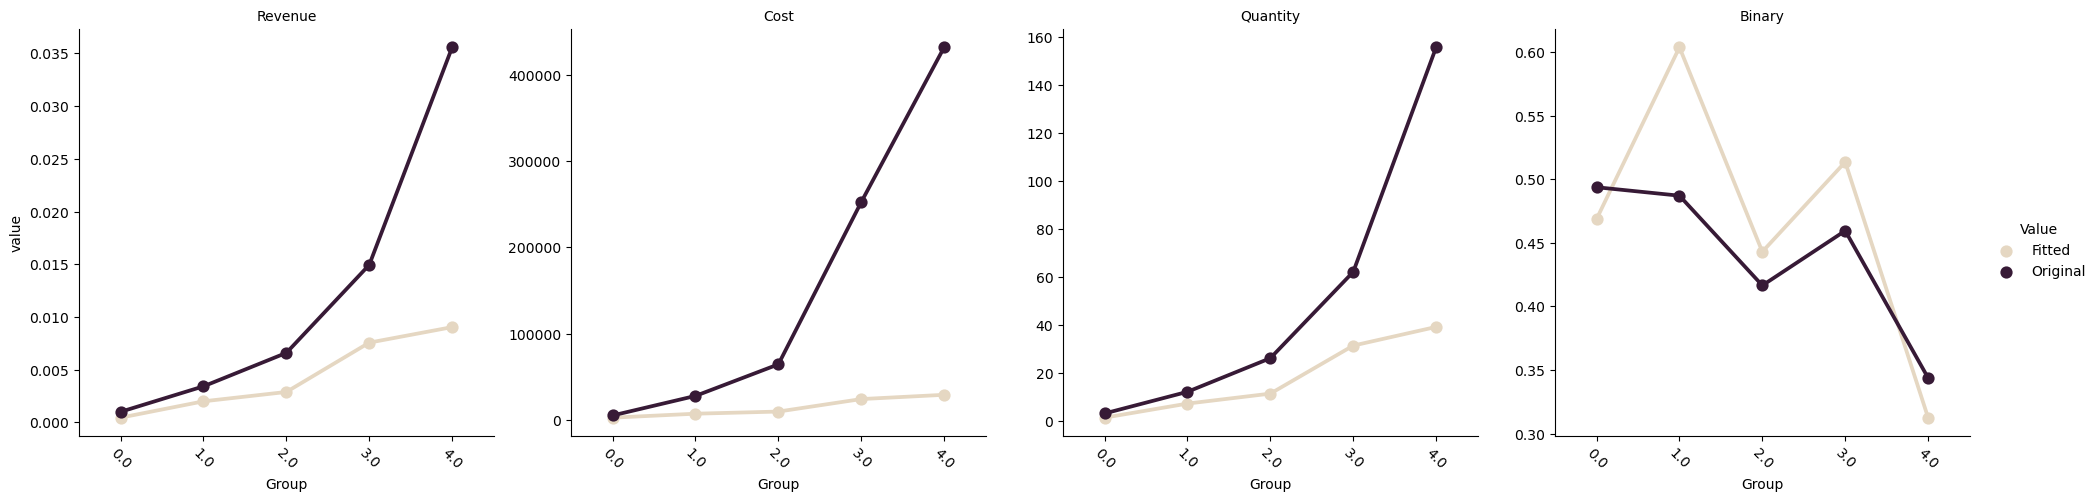

In [165]:
(sns.catplot(data=compare_df.melt(id_vars=['Group', 'Value']),
            x="Group", y="value", hue="Value",
            col="variable", kind="point",
            palette="ch:.25",
            sharey=False)
   .set_titles(col_template="{col_name}")
   .set_xticklabels(rotation=-45))

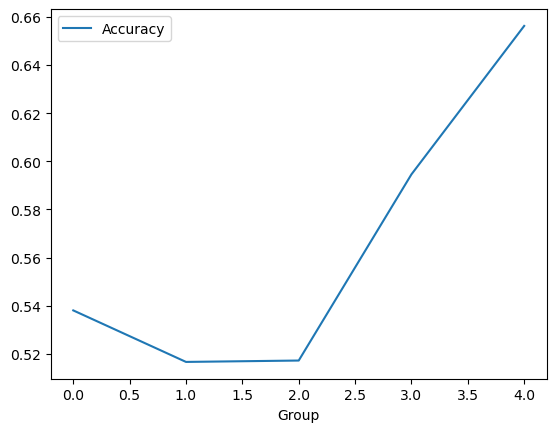

In [184]:
d = pd.concat([opt_data1, rv.rename(columns={"Binary": "Binary_f", "Group": "Group1"})], axis=1)
d['Accuracy'] = np.where(d.Binary == d.Binary_f, 1, 0)
d.groupby('Group').agg({'Accuracy': 'mean'}).plot();